In [ ]:
!pip install --quiet pytesseract pillow easyocr transformers sentence-transformers scikit-learn matplotlib seaborn
!apt-get install -qq -y tesseract-ocr libtesseract-dev


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 20.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 180.7/180.7 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 963.8/963.8 kB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.6/300.6 kB 9.0 MB/s eta 0:00:00
Selecting previously unselected package libarchive-dev:amd64.
(Reading database ... 121703 files and directories currently installed.)
Preparing to unpack .../libarchive-dev_3.6.0-1ubuntu1.5_amd64.deb ...
Unpacking libarchive-dev:amd64 (3.6.0-1ubuntu1.5) ...
Selecting previously unselected package libleptonica-dev.
Preparing to unpack .../libleptonica-dev_1.82.0-3build1_amd64.deb ...
Unpacking libleptonica-dev (1.82.0-3build1) ...
Selecting previously unselected package libtesseract-dev:amd64.
Preparing to unpack .../libtesseract-dev_4.1.1-2.1build1_amd64.deb ...
Unpacking libtesseract-dev:amd64 (4.1.1-2.1build1) ...
Setting up libleptonica-dev (1.82.0-3build1) ...
Setting 

In [ ]:
import os
import glob
import re
from pathlib import Path
import numpy as np
import pandas as pd
from PIL import Image, ImageFilter, ImageOps

import pytesseract
import easyocr

import torch
from transformers import GPT2TokenizerFast, GPT2LMHeadModel
from sentence_transformers import SentenceTransformer

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.metrics import classification_report, confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
from google.colab import files

print("Upload your 34 scanned answer sheet images now.")
uploaded = files.upload()

os.makedirs("images", exist_ok=True)

for name, data in uploaded.items():
    with open(f"images/{name}", "wb") as f:
        f.write(data)

print("Saved all images in /images/")


Upload your 34 scanned answer sheet images now.


Saving AI_with_q_1.jpg to AI_with_q_1.jpg
Saving AI_with_q_2.jpg to AI_with_q_2.jpg
Saving AI_with_q_3.jpg to AI_with_q_3.jpg
Saving AI_with_q_4.jpg to AI_with_q_4.jpg
Saving AI_with_q_5.jpg to AI_with_q_5.jpg
Saving AI_with_q_6.jpg to AI_with_q_6.jpg
Saving AI_with_q_7.jpg to AI_with_q_7.jpg
Saving AI_with_q_8.jpg to AI_with_q_8.jpg
Saving AI_with_q_9.jpg to AI_with_q_9.jpg
Saving AI_with_q_10.jpg to AI_with_q_10.jpg
Saving AI_with_q_11.jpg to AI_with_q_11.jpg
Saving AI_with_q_12.jpg to AI_with_q_12.jpg
Saving AI_with_q_13.jpg to AI_with_q_13.jpg
Saving AI_with_q_14.jpg to AI_with_q_14.jpg
Saving AI_with_q_15.jpg to AI_with_q_15.jpg
Saving AI_with_q_16.jpg to AI_with_q_16.jpg
Saving AI_with_q_17.jpg to AI_with_q_17.jpg
Saving with_q_1.jpg to with_q_1.jpg
Saving with_q_2.jpg to with_q_2.jpg
Saving with_q_3.jpg to with_q_3.jpg
Saving with_q_4.jpg to with_q_4.jpg
Saving with_q_5.jpg to with_q_5.jpg
Saving with_q_6.jpg to with_q_6.jpg
Saving with_q_7.jpg to with_q_7.jpg
Saving with_q_8.jp

In [ ]:
all_files = sorted(glob.glob("images/*"))

rows = []
for f in all_files:
    base = os.path.basename(f).lower()

    # Detect AI vs human
    if base.startswith("ai_with_q_"):
        label = "ai"
    elif base.startswith("with_q_"):
        label = "human"
    else:
        label = "unknown"

    # Extract question number
    # Works for ai_with_q_7 or with_q_15
    digits = re.findall(r"\d+", base)
    qid = int(digits[-1]) if digits else -1

    rows.append({
        "path": f,
        "label": label,
        "qid": qid
    })

df_files = pd.DataFrame(rows)
df_files


,path,label,qid
0,images/AI_with_q_1.jpg,ai,1
1,images/AI_with_q_10.jpg,ai,10
2,images/AI_with_q_11.jpg,ai,11
3,images/AI_with_q_12.jpg,ai,12
4,images/AI_with_q_13.jpg,ai,13
5,images/AI_with_q_14.jpg,ai,14
6,images/AI_with_q_15.jpg,ai,15
7,images/AI_with_q_16.jpg,ai,16
8,images/AI_with_q_17.jpg,ai,17
9,images/AI_with_q_2.jpg,ai,2


In [ ]:
reader = easyocr.Reader(['en'], gpu=False)

def preprocess(img):
    img = img.convert("L")
    img = ImageOps.invert(img)
    img = img.filter(ImageFilter.MedianFilter(size=3))
    base_w = 1800
    wpercent = base_w / img.size[0]
    img = img.resize((base_w, int(img.size[1] * wpercent)), Image.LANCZOS)
    img = ImageOps.autocontrast(img)
    img = ImageOps.invert(img)
    return img

def ocr_easyocr(path):
    img = preprocess(Image.open(path))
    arr = np.array(img)
    results = reader.readtext(arr)
    return "\n".join([r[1] for r in results])

def ocr_tesseract(path):
    img = preprocess(Image.open(path))
    return pytesseract.image_to_string(img, config="--oem 1 --psm 6")


Progress: |██████████████████████████████████████████████████| 100.0% Complete

Progress: |██████████████████████████████████████████████████| 100.0% Complete

In [ ]:
texts = []
for p in df_files["path"]:
    print("OCR on:", p)
    try:
        text = ocr_easyocr(p)
        if len(text.strip()) < 10:
            text = ocr_tesseract(p)
    except:
        text = ocr_tesseract(p)
    texts.append(text)

df_files["ocr_text"] = texts
df_files.head()


OCR on: images/AI_with_q_1.jpg


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


OCR on: images/AI_with_q_10.jpg
OCR on: images/AI_with_q_11.jpg
OCR on: images/AI_with_q_12.jpg
OCR on: images/AI_with_q_13.jpg
OCR on: images/AI_with_q_14.jpg
OCR on: images/AI_with_q_15.jpg
OCR on: images/AI_with_q_16.jpg
OCR on: images/AI_with_q_17.jpg
OCR on: images/AI_with_q_2.jpg
OCR on: images/AI_with_q_3.jpg
OCR on: images/AI_with_q_4.jpg
OCR on: images/AI_with_q_5.jpg
OCR on: images/AI_with_q_6.jpg
OCR on: images/AI_with_q_7.jpg
OCR on: images/AI_with_q_8.jpg
OCR on: images/AI_with_q_9.jpg
OCR on: images/with_q_1.jpg
OCR on: images/with_q_10.jpg
OCR on: images/with_q_11.jpg
OCR on: images/with_q_12.jpg
OCR on: images/with_q_13.jpg
OCR on: images/with_q_14.jpg
OCR on: images/with_q_15.jpg
OCR on: images/with_q_16.jpg
OCR on: images/with_q_17.jpg
OCR on: images/with_q_2.jpg
OCR on: images/with_q_3.jpg
OCR on: images/with_q_4.jpg
OCR on: images/with_q_5.jpg
OCR on: images/with_q_6.jpg
OCR on: images/with_q_7.jpg
OCR on: images/with_q_8.jpg
OCR on: images/with_q_9.jpg


,path,label,qid,ocr_text
0,images/AI_with_q_1.jpg,ai,1,@\nLlAE\n4\nD\nMhaf\ndxaus s\ntoande\nMn_Lab\n...
1,images/AI_with_q_10.jpg,ai,10,@\nLlat\nLpped\nLlun\n#A\nchuc\nCouk\nstuck\n1...
2,images/AI_with_q_11.jpg,ai,11,0\nUut\n2\n4\nLL\nbled2\n4\n2\nLOLst\nBelin\nb...
3,images/AI_with_q_12.jpg,ai,12,Lhat\nf<\nMeah_\ni4 H\n@n\nestb\nCave\npinel\n...
4,images/AI_with_q_13.jpg,ai,13,Pd\nhou)\ndu\nLowe\nSecluded\nIt_\nSanibu\nC\n...


In [ ]:
import unicodedata

def clean_text(t):
    if not isinstance(t, str):
        return ""
    t = unicodedata.normalize("NFKC", t)
    t = re.sub(r"\s+", " ", t)
    t = re.sub(r"[^\x00-\x7F]+", " ", t)
    return t.strip()

df_files["text_clean"] = df_files["ocr_text"].apply(clean_text)
df_files[["path","label","text_clean"]].head()


,path,label,text_clean
0,images/AI_with_q_1.jpg,ai,@ LlAE 4 D Mhaf dxaus s toande Mn_Lab Ls spue ...
1,images/AI_with_q_10.jpg,ai,@ Llat Lpped Llun #A chuc Couk stuck 12 Ax LIl...
2,images/AI_with_q_11.jpg,ai,0 Uut 2 4 LL bled2 4 2 LOLst Belin bahk t 2-fu...
3,images/AI_with_q_12.jpg,ai,Lhat f< Meah_ i4 H @n estb Cave pinel eaxt: 4b...
4,images/AI_with_q_13.jpg,ai,Pd hou) du Lowe Secluded It_ Sanibu C a SiwpU ...


In [ ]:
from collections import Counter

def lexical_features(text):
    words = re.findall(r"\w+", text)
    sents = re.split(r"[.!?]", text)
    punct = Counter(re.findall(r"[.,;:!?]", text))

    return {
        "n_words": len(words),
        "avg_word_len": np.mean([len(w) for w in words]) if words else 0,
        "vocab_size": len(set(words)),
        "ttr": len(set(words)) / len(words) if words else 0,
        "avg_sent_len": np.mean([len(s.split()) for s in sents if len(s.split()) > 0]) if sents else 0,
        "comma_count": punct.get(",", 0),
        "period_count": punct.get(".", 0),
        "question_count": punct.get("?", 0),
    }

lex_df = df_files["text_clean"].apply(lexical_features).apply(pd.Series)


In [ ]:
print("Loading GPT-2...")
tokenizer = GPT2TokenizerFast.from_pretrained("gpt2")
model = GPT2LMHeadModel.from_pretrained("gpt2")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device).eval()

def gpt2_nll(text):
    if len(text.strip()) < 2:
        return 9999
    ids = tokenizer.encode(text)
    chunk = 400
    losses = []
    for i in range(0, len(ids), chunk):
        input_ids = torch.tensor([ids[i:i+chunk]]).to(device)
        with torch.no_grad():
            out = model(input_ids, labels=input_ids)
            losses.append(out.loss.item())
    return float(np.mean(losses))

df_files["gpt2_nll"] = df_files["text_clean"].apply(gpt2_nll)


Loading GPT-2...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

`loss_type=None` was set in the config but it is unrecognized. Using the default loss: `ForCausalLMLoss`.


In [ ]:
sbert = SentenceTransformer("all-MiniLM-L6-v2")

df_files["emb"] = df_files["text_clean"].apply(lambda t: sbert.encode(t))


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
function_words = {
    "the","is","in","and","to","of","a","that","it","for","on","are","as","with","was","by","an"
}

def more_features(text, emb):
    words = re.findall(r"\w+", text.lower())
    n = len(words)
    rare = [w for w in words if len(w) > 6]
    fw = sum(1 for w in words if w in function_words)
    return pd.Series({
        "rare_word_ratio": len(rare)/(n+1),
        "function_word_ratio": fw/(n+1),
        "emb_norm": float(np.linalg.norm(emb))
    })

extra = df_files.apply(lambda r: more_features(r["text_clean"], r["emb"]), axis=1)

df = pd.concat([df_files, lex_df, extra], axis=1)

feature_cols = [
    "n_words","avg_word_len","vocab_size","ttr","avg_sent_len",
    "comma_count","period_count","question_count",
    "gpt2_nll","rare_word_ratio","function_word_ratio","emb_norm"
]

X_basic = df[feature_cols].fillna(0).values
X_emb = np.vstack(df["emb"].values)
X = np.hstack([X_basic, X_emb])

df["y"] = df["label"].map({"human":0, "ai":1})
mask = df["y"].isin([0,1])
X = X[mask]
y = df.loc[mask,"y"].values

print("Feature matrix:", X.shape)


Feature matrix: (34, 396)


In [ ]:
clf = RandomForestClassifier(n_estimators=200, random_state=42)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scores = cross_validate(
    clf, X, y, cv=cv,
    scoring=["accuracy","f1"],
    return_estimator=True
)

print("Accuracy:", scores["test_accuracy"])
print("F1:", scores["test_f1"])
print("Mean Acc:", np.mean(scores["test_accuracy"]))


Accuracy: [0.71428571 0.42857143 0.71428571 0.57142857 0.83333333]
F1: [0.75       0.5        0.66666667 0.57142857 0.85714286]
Mean Acc: 0.6523809523809525


              precision    recall  f1-score   support

       human       1.00      1.00      1.00        17
          ai       1.00      1.00      1.00        17

    accuracy                           1.00        34
   macro avg       1.00      1.00      1.00        34
weighted avg       1.00      1.00      1.00        34



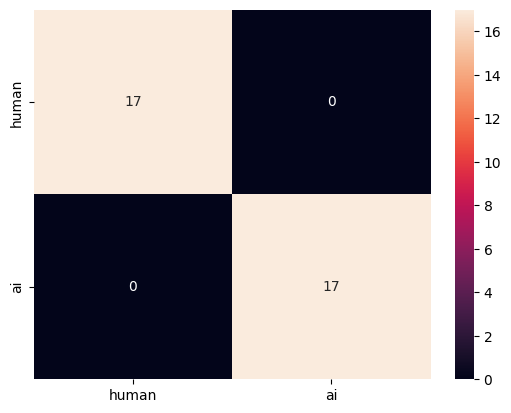

In [ ]:
clf_final = RandomForestClassifier(n_estimators=400, random_state=42)
clf_final.fit(X, y)

pred = clf_final.predict(X)
probs = clf_final.predict_proba(X)[:,1]

print(classification_report(y, pred, target_names=["human","ai"]))

cm = confusion_matrix(y, pred)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=['human','ai'], yticklabels=['human','ai'])
plt.show()


In [ ]:
import joblib
os.makedirs("artifacts", exist_ok=True)

joblib.dump(clf_final, "artifacts/model.joblib")

out = df.loc[mask, ["path","label","text_clean"]].copy()
out["pred"] = pred
out["prob_ai"] = probs
out.to_csv("artifacts/predictions.csv", index=False)

print("Saved artifacts/model.joblib and artifacts/predictions.csv")


Saved artifacts/model.joblib and artifacts/predictions.csv


In [ ]:
from google.colab import files
files.download("artifacts/predictions.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [4]:
import nbformat
from google.colab import files

# Path to your notebook
notebook_path = "/content/handwritten_answers.ipynb"

# Load notebook
with open(notebook_path, "r") as f:
    nb = nbformat.read(f, as_version=4)

# Remove broken widget metadata
if "widgets" in nb["metadata"]:
    del nb["metadata"]["widgets"]

# Save cleaned notebook
clean_path = "/content/handwritten_answers_clean.ipynb"
with open(clean_path, "w") as f:
    nbformat.write(nb, f)

# Download cleaned notebook
files.download(clean_path)


FileNotFoundError: [Errno 2] No such file or directory: '/content/handwritten_answers.ipynb'